In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sigproc_kit import *
import random

In [2]:
#%matplotlib notebook

def QFM(t,vp,**kwargs):
  delay = kwargs.get("delay",5e-9)
  vcc = kwargs.get("vcc",3.3)
  c = 10e-12
  r = 3.3e3
  dt = t[1]-t[0]
  uc = t * 0
  logic_out = t * 0
  uc[0] = 0
  
  wait = 0
  triggered = 0

  charge_state = 0
  wait_state      = 1
    
  state = charge_state
    
  for i in range(0,len(t)-1):
    
    
    if (uc[i] < vp[i]) and (state == charge_state): # not hit the threshold from above
      i_chr = (vcc-uc[i])/r
      uc[i+1] = uc[i] + i_chr*dt/c
    else: # hit the threshold from above
      uc[i+1] = 0
      logic_out[i+1] = 1
      if state == charge_state:
        wait = delay
        state = wait_state
    
    if state == wait_state:
      wait = wait - dt
        
    if (wait <= 0):
      wait = 0
      state = charge_state
    
    
  return (logic_out, uc)


In [3]:
t = np.linspace(0,750e-9,50000)
vp = t*0 +0.5


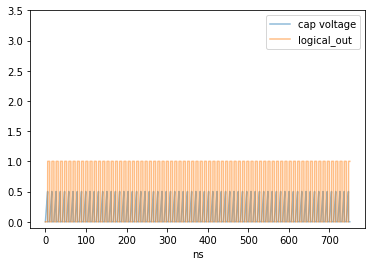

In [4]:
logic_out, uc = QFM(t,vp)

plt.plot(t*1e9,uc,alpha=0.5,label="cap voltage")
plt.plot(t*1e9,logic_out,alpha=0.5,label="logical_out")
plt.xlabel("ns")
plt.ylim(-0.1,3.5)
plt.legend()
#plt.xlim(0,100)
plt.show()



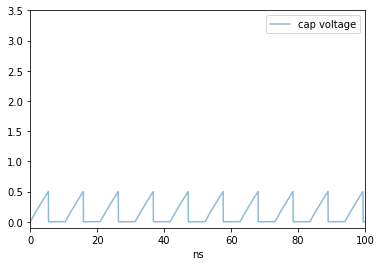

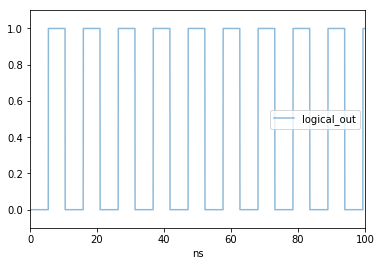

In [5]:
logic_out, uc = QFM(t,vp)

plt.plot(t*1e9,uc,alpha=0.5,label="cap voltage")
#plt.plot(t*1e9,logic_out,alpha=0.5,label="logical_out")
plt.xlabel("ns")
plt.ylim(-0.1,3.5)
plt.legend()
plt.xlim(0,100)
plt.show()

#plt.plot(t*1e9,uc,alpha=0.5,label="cap voltage")
plt.plot(t*1e9,logic_out,alpha=0.5,label="logical_out")
plt.xlabel("ns")
plt.ylim(-0.1,1.1)
plt.legend()
plt.xlim(0,100)
plt.show()



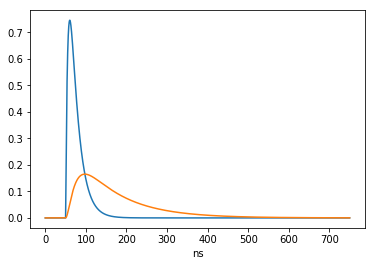

In [6]:
Q = 500e-12
tau1 = 6e-9
tau2 = 20e-9
modulation  = detector_signal_function(t, Q, tau1, tau2, 50e-9)

R=1e3
C=100e-12
mod_rc = RC_filter(t,modulation,R,C)

plt.plot(t*1e9,modulation)
plt.plot(t*1e9,mod_rc)
plt.xlabel("ns")
plt.show()



# use filtered modulation

modulation = mod_rc

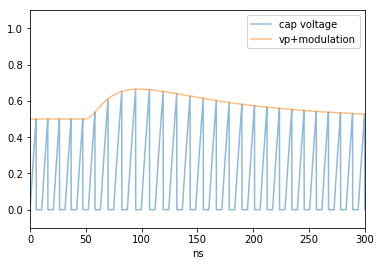

In [7]:


logic_out, uc = QFM(t,vp+modulation)

plt.plot(t*1e9,uc,alpha=0.5,label="cap voltage")
#plt.plot(t*1e9,logic_out,alpha=0.5,label="logical_out")
plt.plot(t*1e9,vp+modulation,alpha=0.5,label="vp+modulation")
plt.xlabel("ns")
plt.ylim(-0.1,1.1)
plt.legend()
plt.xlim(0,300)
plt.show()



In [8]:
def measure(Q):
    
  n = 50

  logic_out, uc = QFM(t,vp)
  TN_a = nth_edge_time(t,logic_out,n)
  TDiff_list = []

  for i in range(0,100):
    rand_delay = random.random()*20e-9
  
    modulation  = detector_signal_function(t, Q, tau1, tau2, 50e-9+rand_delay)
  
    R=1e3
    C=100e-12
    mod_rc = RC_filter(t,modulation,R,C)
    modulation = mod_rc
  
  
  
    logic_out, uc = QFM(t,vp+modulation)
    TN_b = nth_edge_time(t,logic_out,n)
    TDiff = TN_b -TN_a
  
    TDiff_list += [TDiff]
  
  TDiff_list = np.array(TDiff_list)
    
  TDiff = np.mean(TDiff_list)
  
  jitter = np.std(TDiff_list)
  jitter_relative = jitter/TDiff
  
  #print("Q = {:3.3f} pC".format(Q*1e12))
  
  #print("jitter = {:3.3f} ps".format(jitter*1e12))
  #print("relative jitter {:3.3f}%".format(jitter_relative*100))
  #print("Q jitter = {:3.3f} pC".format(Q*1e12*jitter_relative))
  
  #jitter_Q = jitter_relative* Q

  return TDiff, jitter

In [9]:

steps = 30

Qmax = 600e-12

Q_list = []
TDiff_list = []
jitter_list = []


for Q in np.linspace(0,Qmax,steps):
  TDiff, jitter = measure(Q)
  Q_list += [Q]
  TDiff_list += [TDiff]
  jitter_list += [jitter]
    
TDiff_list = np.array(TDiff_list)
Q_list = np.array(Q_list)
jitter_list = np.array(jitter_list)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


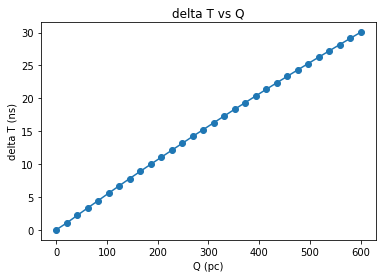

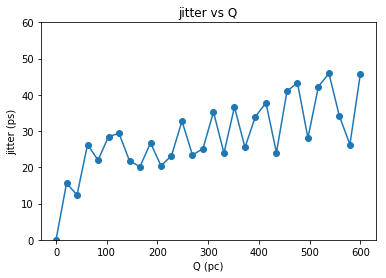

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


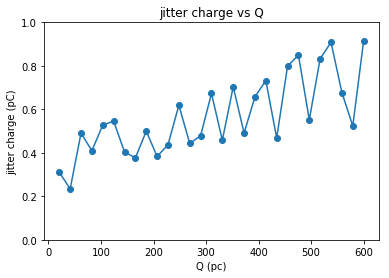

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


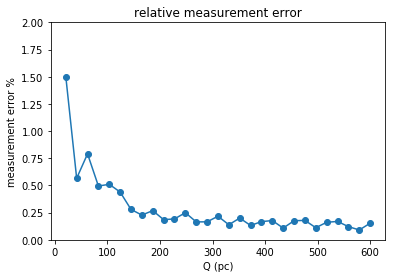

In [12]:
plt.scatter(Q_list*1e12,TDiff_list*1e9)
plt.plot(Q_list*1e12,TDiff_list*1e9)
plt.xlabel("Q (pc)")
plt.ylabel("delta T (ns)")
plt.title("delta T vs Q")
plt.show()

plt.scatter(Q_list*1e12,jitter_list*1e12)
plt.plot(Q_list*1e12,jitter_list*1e12)
plt.xlabel("Q (pc)")
plt.ylabel("jitter (ps)")
plt.title("jitter vs Q")
plt.ylim(0,60)
plt.show()

plt.scatter(Q_list*1e12,jitter_list/TDiff_list*Q_list*1e12)
plt.plot(Q_list*1e12,jitter_list/TDiff_list*Q_list*1e12)
plt.xlabel("Q (pc)")
plt.ylabel("jitter charge (pC)")
plt.title("jitter charge vs Q")
plt.ylim(0,1)
plt.show()

plt.scatter(Q_list*1e12,jitter_list/TDiff_list*100)
plt.plot(Q_list*1e12,jitter_list/TDiff_list*100)
plt.xlabel("Q (pc)")
plt.ylabel("measurement error %")
plt.title("relative measurement error")
plt.ylim(0,2)
plt.show()